<a href="https://colab.research.google.com/github/tmforai60/zerotsuku3/blob/main/Step_29_32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

#### これまで作ったコード（core_simple.py等）

In [2]:
!git clone https://github.com/oreilly-japan/deep-learning-from-scratch-3.git

fatal: destination path 'deep-learning-from-scratch-3' already exists and is not an empty directory.


In [3]:
import os
os.chdir('/content/deep-learning-from-scratch-3')

In [4]:
import weakref
import numpy as np
import contextlib


# =============================================================================
# Config
# =============================================================================
class Config:
    enable_backprop = True


@contextlib.contextmanager
def using_config(name, value):
    old_value = getattr(Config, name)
    setattr(Config, name, value)
    try:
        yield
    finally:
        setattr(Config, name, old_value)


def no_grad():
    return using_config('enable_backprop', False)


# =============================================================================
# Variable / Function
# =============================================================================
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data # ndarrayインスタンス
        self.name = name
        self.grad = None # ndarrayインスタンス
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            self.grad = np.ones_like(self.data)

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x


class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


# =============================================================================
# 四則演算 / 演算子のオーバーロード
# =============================================================================
class Add(Function):
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow

In [5]:
# 演算子のオーバーロード
setup_variable()
__version__ = '0.0.13'


## Step29: ニュートン法を用いた最適化（手計算）
---



### ニュートン法について
- 一般的には初期値が解に近ければニュートン法のほうが早く収束する  
(勾配降下法はローゼンブロック関数のような谷間が長く伸びた関数が苦手)

- 手順
  1. 初期値xを決める
  2. その点における、テイラー展開（二階微分まで）を考え、二次関数で近似する  
  3. 近似した二次関数の最小値を与えるx_newを求める
  4. xをx_newで更新
  5. 2から4を繰り返す

$f(x) = x^4 - 2 x^2 を例にニュートン法を考える $

In [6]:
# 元の関数
def f(x):
  return x ** 4 - 2 * x ** 2

# テイラー展開に必要な一階微分と二階微分
def f_1(x):
  return 4 * x ** 3 - 4 * x

def f_2(x):
  return 12 * x ** 2 - 4

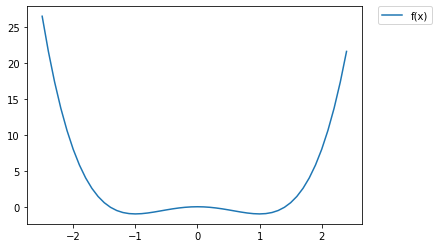

In [7]:
# 元の関数のグラフ
x = np.arange(-2.5, 2.5, 0.1)
y = f(x)

plt.plot(x, y, label='f(x)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

1回目の近似関数の最小値をとるx:  1.4545454545454546
2回目の近似関数の最小値をとるx:  1.1510467893775467
3回目の近似関数の最小値をとるx:  1.0253259289766978
4回目の近似関数の最小値をとるx:  1.0009084519430513
5回目の近似関数の最小値をとるx:  1.0000012353089454
6回目の近似関数の最小値をとるx:  1.000000000002289
7回目の近似関数の最小値をとるx:  1.0
8回目の近似関数の最小値をとるx:  1.0
9回目の近似関数の最小値をとるx:  1.0
10回目の近似関数の最小値をとるx:  1.0


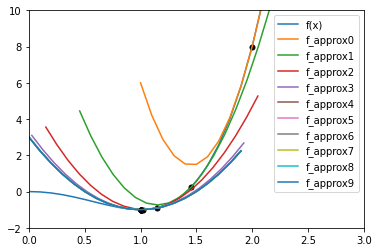

In [8]:
## ニュートン法

# 試行回数
n = 10

# f(x)の描画
x = np.arange(-2.5, 2.5, 0.1)
y = f(x)
plt.plot(x, y, label='f(x)')


a = 2.0 # 初期値

for i in range(n):
  x = np.arange(a-1, a+1, 0.1)
  f_approx_at_a = f(a) + f_1(a) * (x - a) + 1/2 * f_2(a) * (x - a) ** 2
  plt.plot(a, f(a), marker='.', color='black', markersize=10)
  plt.plot(x, f_approx_at_a, label=f'f_approx{i}')
  a = a - f_1(a) / f_2(a) # 近似した二次関数の最小値をとるx
  print(f'{i+1}回目の近似関数の最小値をとるx: ', a)

plt.ylim(-2, 10)
plt.xlim(0, 3)
plt.legend()
plt.show()

テイラー展開（二階微分まで）
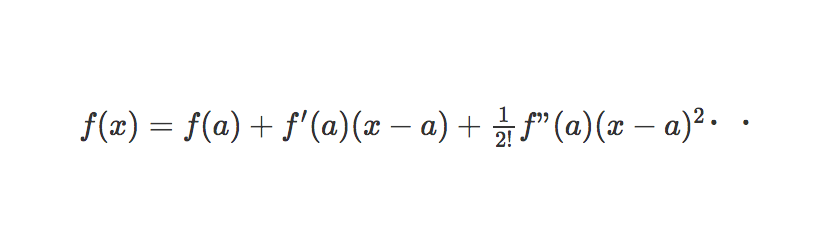

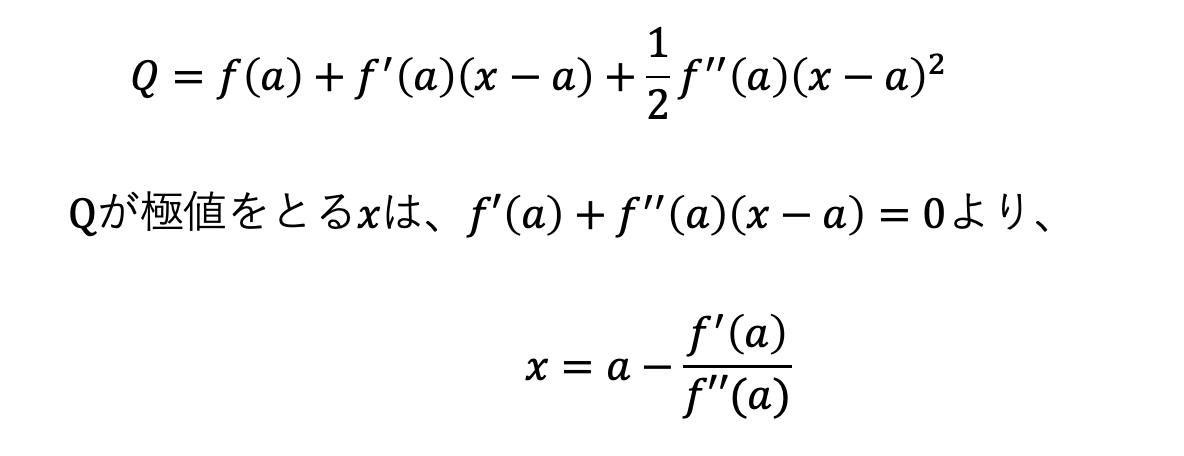

### dezeroを使ったニュートン法の計算

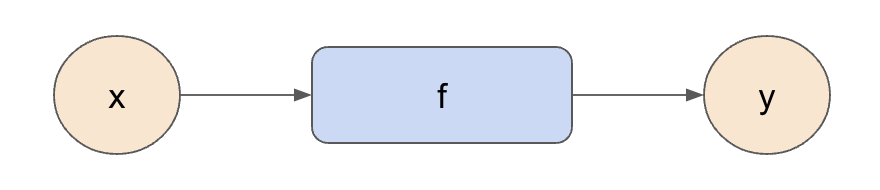

In [9]:
# 元の関数
def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

# 二階微分（現行dezeroでは未実装）
def gx2(x):
  return 12 * x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward()

  x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


###(比較)dezeroを使った勾配降下法の計算

In [10]:
# 元の関数
def f(x):
  y = x ** 4 - 2 * x ** 2
  return y

# 学習率
lr = 0.01

x = Variable(np.array(2.0))
iters = 50

for i in range(iters):
  print(i, x)

  y = f(x)
  x.cleargrad()
  y.backward()

  x.data -= lr * x.grad

0 variable(2.0)
1 variable(1.76)
2 variable(1.61232896)
3 variable(1.5091654023014192)
4 variable(1.4320422081467723)
5 variable(1.3718537670818505)
6 variable(1.3234557123052246)
7 variable(1.2836707795677516)
8 variable(1.2504077544406735)
9 variable(1.22222258571841)
10 variable(1.1980798739184826)
11 variable(1.177214336033959)
12 variable(1.1590459825555366)
13 variable(1.143125902304502)
14 variable(1.129100349749648)
15 variable(1.1166862256266712)
16 variable(1.1056538960762419)
17 variable(1.0958148793962101)
18 variable(1.0870128450049137)
19 variable(1.079116917392435)
20 variable(1.0720166163554925)
21 variable(1.0656179796242096)
22 variable(1.0598405536403568)
23 variable(1.054615031023873)
24 variable(1.0498813761162078)
25 variable(1.0455873233277237)
26 variable(1.041687163385328)
27 variable(1.0381407541727987)
28 variable(1.0349127084231744)
29 variable(1.0319717218840727)
30 variable(1.029290013965064)
31 variable(1.0268428591358087)
32 variable(1.0246081920613856)


### (補足)ニュートン法が使えない条件
- ヘッセ行列の計算ができないと破綻
- ヘッセ行列が正則でないと破綻
- ヘッセ行列が正定値でないと目的関数値が増加することがある

ニュートン法が使えない場合は多くはない。
また、ニュートン法は変数が増えるにつれ計算コストがどんどん大きくなる傾向にある。

###(参考資料)
※ヘッセ行列と正定値についての参考資料  
1. wikipedia「ヘッセ行列」
https://ja.wikipedia.org/wiki/%E3%83%98%E3%83%83%E3%82%BB%E8%A1%8C%E5%88%97. 
2. 多変数関数の極値判定とヘッセ行列
https://manabitimes.jp/math/1163　　
3. 数理計画法（数理最適化）第13回非線形計画(塩浦昭義氏)
http://www.dais.is.tohoku.ac.jp/~shioura/teaching/mp13/mp13-13.pdf

使えない例） $y = x^4 - 4x^2　（初期値\sqrt{2/3}）$

（※このときヘッセ行列はHf(x）=-5で正則でない）

1回目の近似関数の最小値をとるx:  inf


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
Traceback (most recent call last):
  File "<ipython-input-11-0b647e212254>", line 29, in <module>
    x = np.arange(a-1, a+1, 0.1)
ValueError: arange: cannot compute length


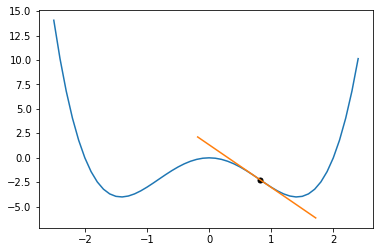

In [11]:
try:
      
  # 元の関数
  def f(x):
    return x ** 4 - 4 * x ** 2

  # テイラー展開に必要な一階微分と二階微分
  def f_1(x):
    return 4 * x ** 3 - 8 * x

  def f_2(x):
    return 12 * x ** 2 - 8



  # 試行回数
  n = 10

  # f(x)の描画
  x = np.arange(-2.5, 2.5, 0.1)
  y = f(x)
  plt.plot(x, y, label='f(x)')


  # ニュートン法
  a = np.sqrt(2/3) # 初期値

  for i in range(n):
    x = np.arange(a-1, a+1, 0.1)
    f_approx_at_a = f(a) + f_1(a) * (x - a) + 1/2 * f_2(a) * (x - a) ** 2
    plt.plot(a, f(a), marker='.', color='black', markersize=10)
    plt.plot(x, f_approx_at_a, label=f'f_approx{i}')
    a = a - f_1(a) / f_2(a) # 近似した二次関数の最小値をとるx
    print(f'{i+1}回目の近似関数の最小値をとるx: ', a)

  plt.ylim(-2, 10)
  plt.xlim(0, 3)
  plt.legend()
  plt.show()

except ValueError:
  import traceback
  traceback.print_exc()

f''(a)=0となるため二次関数に近似できていない
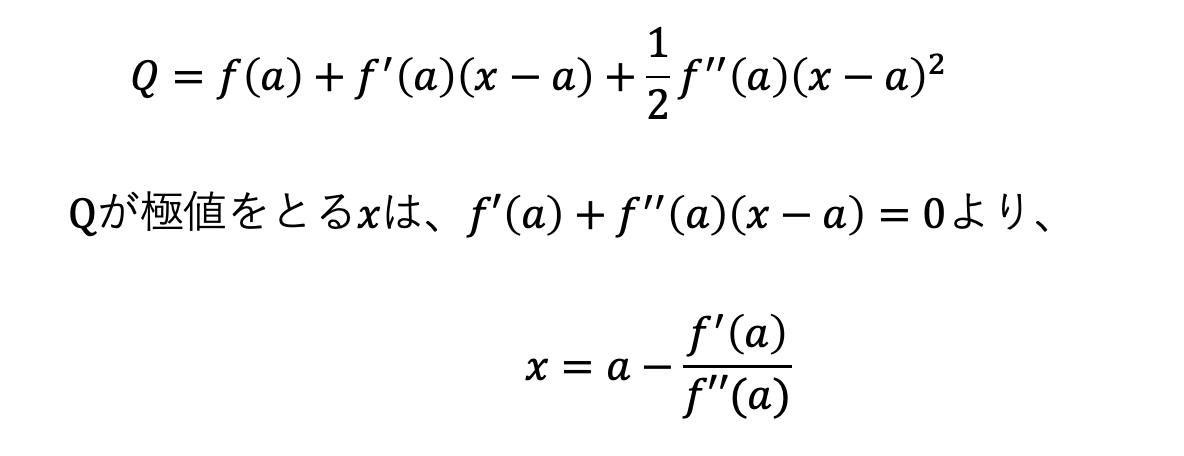

ニュートン法は、極大値に向かう場合や循環する場合もある。循環する可能性に備え、ニュートン法は予め最大試行回数を決めて実施することが望ましいとするサイトもあり。

## Step30〜31: 高階微分
---

- ステップ29で試したニュートン法では一階微分と二階微分を使うが、dezeroは一階微分しか自動化できていない。
- 二階微分、三階微分…といった高階微分を自動で求められるようdezeroを拡張する

現行Dezeroの課題点
- 逆伝播はndarrayインスタンスで計算しているため計算の繋がり（計算グラフ）が作られない。  
→ DeZeroでは、Variableインスタンスを使って通常の計算（順伝播）を行うタイミング(具体的にはFunctionクラスの`__call__`メソッド)で「つながり」が作られる  
→backwardメソッドでもVariableインスタンスを使い、Functionクラスの`__call__`メソッドを使うことで解決できる

### Sinクラスで確認

In [12]:
# 実装済のSinクラス

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y
  
  def backward(self, gy):
    x = self.inputs[0].data
    gx = gy * np.cos(x)
    return gx

y = sin(x)の微分を求める計算グラフ
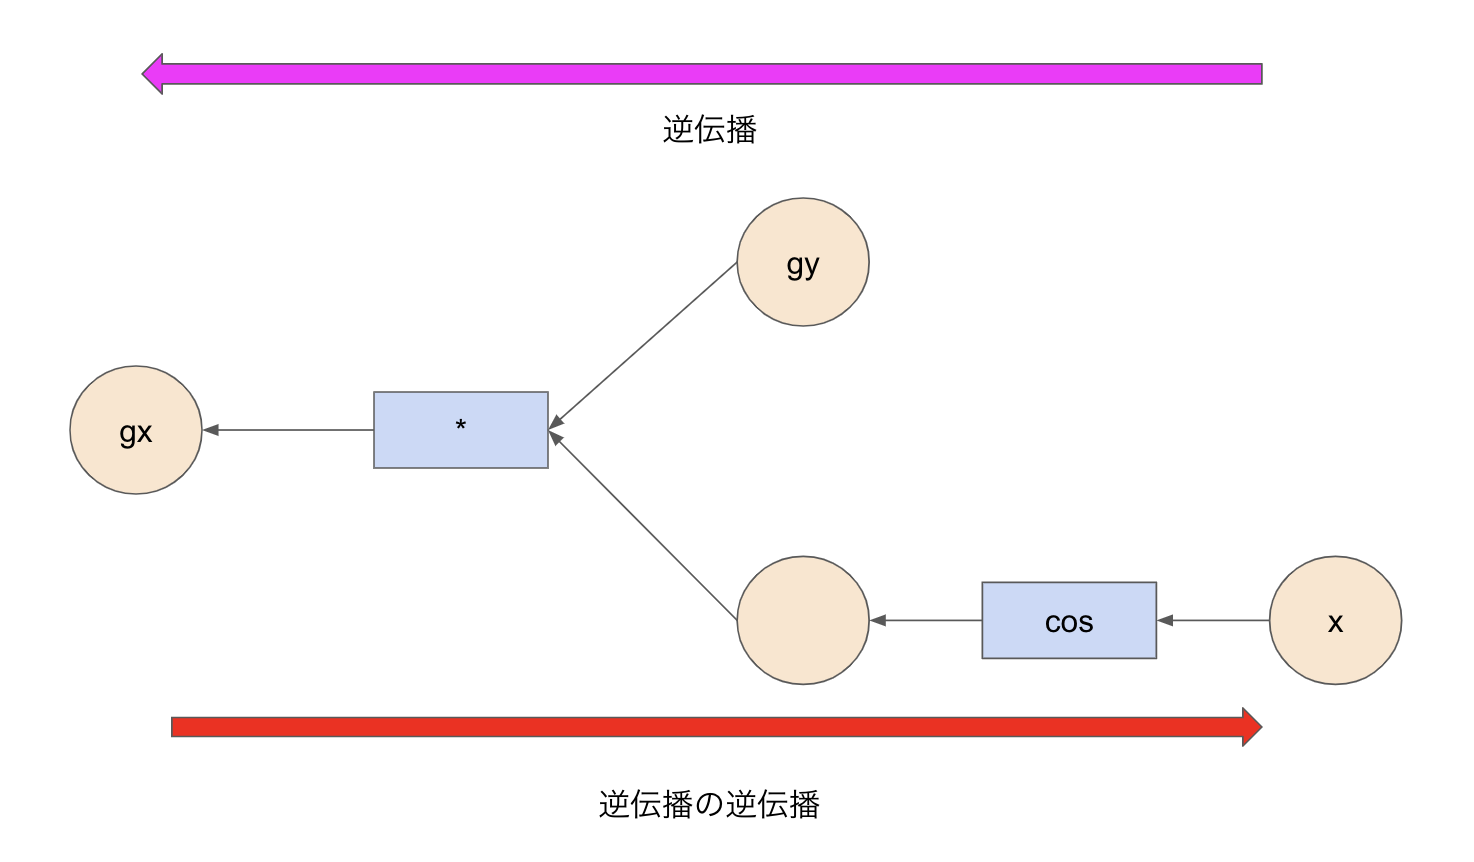

####準備  
勾配をVariableインスタンスとして保持する形に変更

## Step32: 高階微分（実装編）
---

- gradをndarrayインスタンスからVariableインスタンスに変更

Variableクラスの変更

In [13]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False):
        if self.grad is None:
            #self.grad = np.ones_like(self.data)
            self.grad = Variable(np.ones_like(self.data)) # Variableインスタンスに変更

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]
            gxs = f.backward(*gys)
            if not isinstance(gxs, tuple):
                gxs = (gxs,)

            for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

            if not retain_grad:
                for y in f.outputs:
                    y().grad = None


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

Functionクラスの逆伝播の変更
- Addクラスは変更なし（何も計算は行われないため）
- Mulクラスは修正必要あり
- 【問題】Neg, Sub, Div, Powクラスのbackwardメソッドを修正しなさい。

In [14]:
# Mulクラスの変更

class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


# =============================================================================
# 四則演算 / 演算子のオーバーロード
# =============================================================================
class Add(Function): 
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    # def backward(self, gy):
    #     x0, x1 = self.inputs[0].data, self.inputs[1].data
    #     return gy * x1, gy * x0

    def backward(self, gy):
      x0, x1 = self.inputs
      return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function):
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function):
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)


class Div(Function):
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    def backward(self, gy):
        x0, x1 = self.inputs[0].data, self.inputs[1].data
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)


class Pow(Function):
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    def backward(self, gy):
        x = self.inputs[0].data
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx

def pow(x, c):
    return Pow(c)(x)

def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow

In [15]:
# 問題の解答

class Function:
    def __call__(self, *inputs):
        inputs = [as_variable(x) for x in inputs]

        xs = [x.data for x in inputs]
        ys = self.forward(*xs)
        if not isinstance(ys, tuple):
            ys = (ys,)
        outputs = [Variable(as_array(y)) for y in ys]

        if Config.enable_backprop:
            self.generation = max([x.generation for x in inputs])
            for output in outputs:
                output.set_creator(self)
            self.inputs = inputs
            self.outputs = [weakref.ref(output) for output in outputs]

        return outputs if len(outputs) > 1 else outputs[0]

    def forward(self, xs):
        raise NotImplementedError()

    def backward(self, gys):
        raise NotImplementedError()


# =============================================================================
# 四則演算 / 演算子のオーバーロード
# =============================================================================
class Add(Function): 
    def forward(self, x0, x1):
        y = x0 + x1
        return y

    def backward(self, gy):
        return gy, gy


def add(x0, x1):
    x1 = as_array(x1)
    return Add()(x0, x1)


class Mul(Function):
    def forward(self, x0, x1):
        y = x0 * x1
        return y

    def backward(self, gy):
      x0, x1 = self.inputs
      return gy * x1, gy * x0


def mul(x0, x1):
    x1 = as_array(x1)
    return Mul()(x0, x1)


class Neg(Function): # 変更なし
    def forward(self, x):
        return -x

    def backward(self, gy):
        return -gy


def neg(x):
    return Neg()(x)


class Sub(Function): # 変更なし
    def forward(self, x0, x1):
        y = x0 - x1
        return y

    def backward(self, gy):
        return gy, -gy


def sub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x0, x1)


def rsub(x0, x1):
    x1 = as_array(x1)
    return Sub()(x1, x0)


class Div(Function): # 変更あり
    def forward(self, x0, x1):
        y = x0 / x1
        return y

    # def backward(self, gy):
    #     x0, x1 = self.inputs[0].data, self.inputs[1].data
    #     gx0 = gy / x1
    #     gx1 = gy * (-x0 / x1 ** 2)
    #     return gx0, gx1

    def backward(self, gy):
        x0, x1 = self.inputs
        gx0 = gy / x1
        gx1 = gy * (-x0 / x1 ** 2)
        return gx0, gx1


def div(x0, x1):
    x1 = as_array(x1)
    return Div()(x0, x1)


def rdiv(x0, x1):
    x1 = as_array(x1)
    return Div()(x1, x0)


class Pow(Function): # 変更あり
    def __init__(self, c):
        self.c = c

    def forward(self, x):
        y = x ** self.c
        return y

    # def backward(self, gy):
    #     x = self.inputs[0].data
    #     c = self.c

    #     gx = c * x ** (c - 1) * gy
    #     return gx

    def backward(self, gy):
        x = self.inputs
        c = self.c

        gx = c * x ** (c - 1) * gy
        return gx


def pow(x, c):
    return Pow(c)(x)

def setup_variable():
    Variable.__add__ = add
    Variable.__radd__ = add
    Variable.__mul__ = mul
    Variable.__rmul__ = mul
    Variable.__neg__ = neg
    Variable.__sub__ = sub
    Variable.__rsub__ = rsub
    Variable.__truediv__ = div
    Variable.__rtruediv__ = rdiv
    Variable.__pow__ = pow

逆伝播の中で行う計算に対して逆伝播の有効・無効モードを導入

In [16]:
class Variable:
    __array_priority__ = 200

    def __init__(self, data, name=None):
        if data is not None:
            if not isinstance(data, np.ndarray):
                raise TypeError('{} is not supported'.format(type(data)))

        self.data = data
        self.name = name
        self.grad = None
        self.creator = None
        self.generation = 0

    @property
    def shape(self):
        return self.data.shape

    @property
    def ndim(self):
        return self.data.ndim

    @property
    def size(self):
        return self.data.size

    @property
    def dtype(self):
        return self.data.dtype

    def __len__(self):
        return len(self.data)

    def __repr__(self):
        if self.data is None:
            return 'variable(None)'
        p = str(self.data).replace('\n', '\n' + ' ' * 9)
        return 'variable(' + p + ')'

    def set_creator(self, func):
        self.creator = func
        self.generation = func.generation + 1

    def cleargrad(self):
        self.grad = None

    def backward(self, retain_grad=False, create_graph=False): # 変更箇所
        if self.grad is None:
            self.grad = Variable(np.ones_like(self.data))

        funcs = []
        seen_set = set()

        def add_func(f):
            if f not in seen_set:
                funcs.append(f)
                seen_set.add(f)
                funcs.sort(key=lambda x: x.generation)

        add_func(self.creator)

        while funcs:
            f = funcs.pop()
            gys = [output().grad for output in f.outputs]

            with using_config('enable_backprop', create_graph): # 変更箇所
              gxs = f.backward(*gys)
              if not isinstance(gxs, tuple):
                gxs = (gxs,)
              
              for x, gx in zip(f.inputs, gxs):
                if x.grad is None:
                    x.grad = gx
                else:
                    x.grad = x.grad + gx

                if x.creator is not None:
                    add_func(x.creator)

              if not retain_grad:
                  for y in f.outputs:
                      y().grad = None


def as_variable(obj):
    if isinstance(obj, Variable):
        return obj
    return Variable(obj)


def as_array(x):
    if np.isscalar(x):
        return np.array(x)
    return x

__init__.pyの変更
- ここからはdezero/core_simple.pyではなくdezero/core.pyを利用するためis_simple_core=Falseに変更

In [17]:
# =============================================================================
# step23.pyからstep32.pyまではsimple_coreを利用
is_simple_core = False  # True
# =============================================================================

if is_simple_core:
    from dezero.core_simple import Variable
    from dezero.core_simple import Function
    from dezero.core_simple import using_config
    from dezero.core_simple import no_grad
    from dezero.core_simple import as_array
    from dezero.core_simple import as_variable
    from dezero.core_simple import setup_variable

else:
    from dezero.core import Variable
    from dezero.core import Parameter
    from dezero.core import Function
    from dezero.core import using_config
    from dezero.core import no_grad
    from dezero.core import test_mode
    from dezero.core import as_array
    from dezero.core import as_variable
    from dezero.core import setup_variable
    from dezero.core import Config
    from dezero.layers import Layer
    from dezero.models import Model
    from dezero.datasets import Dataset
    from dezero.dataloaders import DataLoader
    from dezero.dataloaders import SeqDataLoader

    import dezero.datasets
    import dezero.dataloaders
    import dezero.optimizers
    import dezero.functions
    import dezero.functions_conv
    import dezero.layers
    import dezero.utils
    import dezero.cuda
    import dezero.transforms

setup_variable()
__version__ = '0.0.13'